In [1]:
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score

import torch
import torch.nn
import torch.optim
import torch.utils.data

import time
import math

In [2]:
import importlib
import LearningCutsUtils.LearningCutsUtils
## needed if we change LearningCutsUtils and want to avoid reloading the kernel to see the effects
importlib.reload(LearningCutsUtils.LearningCutsUtils)
import LearningCutsUtils.LearningCutsUtils as LCU
from LearningCutsUtils.LearningCutsUtils import getBack, ListToGraph, OneToOneLinear, OneToOneLinearActivation, EfficiencyScanNetwork
from LearningCutsUtils.LearningCutsUtils import loss_fn
from LearningCutsUtils.LearningCutsUtils import effic_loss_fn

In [3]:
N=20000 # number of points
m=10 # dimensions

In [4]:
# array of means and widths for gaussians,
# indices are:
# - number of dimensions
# - signal (0) vs background (1)
# - mean (0) vs width (1)
np.random.seed(123)

# if we want more control over the function, for example
means_widths=[[[4,0.4],
               [-2,.10]],
              [[3,1.0],
               [-1,0.5]]]

means_widths=np.random.randn(m,2,2)               
width_scale_factor=2.
mean_scale_factor=2.

# now construct the training data.  after taking transpose, should be N rows by m columns.  
x_signal=np.array([means_widths[i][0][0]+width_scale_factor*np.fabs(means_widths[i][0][1])*np.random.randn(N) for i in range(m)]).T
y_signal=np.ones(N)
x_backgr=np.array([means_widths[i][1][0]+width_scale_factor*np.fabs(means_widths[i][1][1])*np.random.randn(N) for i in range(m)]).T
y_backgr=np.zeros(N)
x=np.concatenate((x_signal,x_backgr))
y=np.concatenate((y_signal,y_backgr))

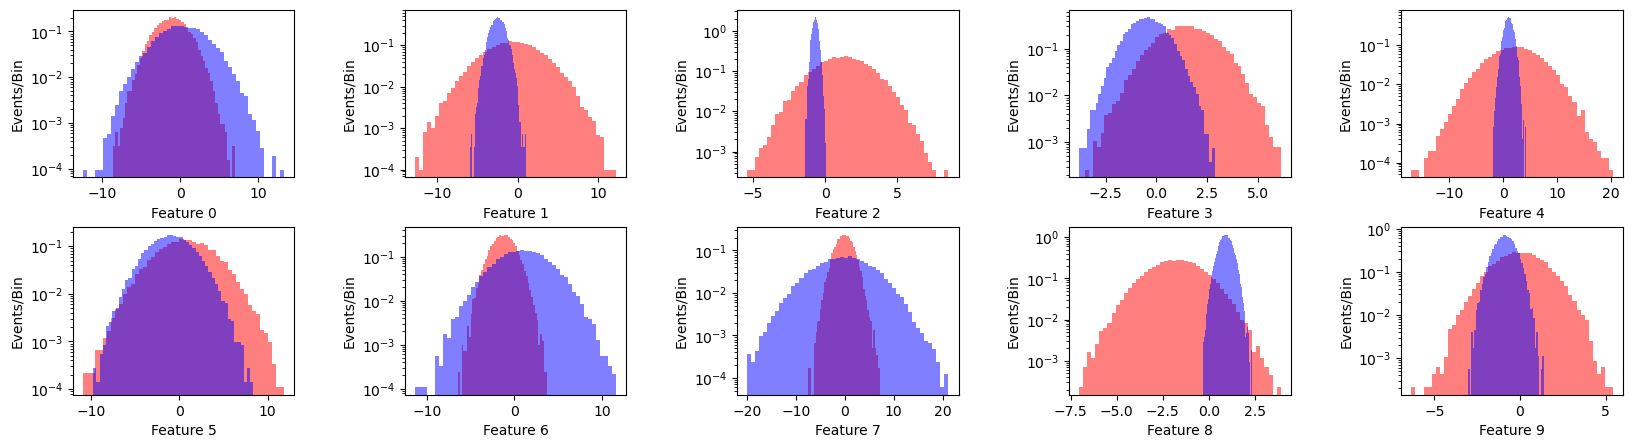

In [5]:
fig = plt.figure(figsize=(20,5))
fig.tight_layout()
nbins=50

for b in range(m):
    ax=fig.add_subplot(2,5,1+b)
    plt.subplots_adjust(hspace=0.3,wspace=0.5)
    plt.yscale('log')
    ax.hist(x_signal[:,b],nbins,density=True,histtype='stepfilled',alpha=0.5,color='red')
    ax.hist(x_backgr[:,b],nbins,density=True,histtype='stepfilled',alpha=0.5,color='blue')
    ax.set_xlabel(f"Feature {b}")
    ax.set_ylabel("Events/Bin")

In [6]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

sc = StandardScaler()
x_train_scaled = sc.fit_transform(x_train)
x_test_scaled  = sc.transform(x_test)

In [7]:
x_train_tensor=torch.tensor(x_train_scaled,dtype=torch.float)
y_train_tensor=torch.tensor(y_train,dtype=torch.float)

x_test_tensor=torch.tensor(x_test_scaled,dtype=torch.float)
y_test_tensor=torch.tensor(y_test,dtype=torch.float)

In [8]:
gt=1.
lt=-1.
cuts_gt_lt = [lt, gt, gt, gt, lt,
              gt, lt, lt, lt, gt]

In [9]:
# some hyperparameters
torch.manual_seed(123)
activation_input_scale_factor=8.
learning_rate=0.02
batch_size=int(len(y_train)/20.) #
epochs=100
alpha=10.   # scaling factor to tune how important hitting the target signal efficiency is
beta=10.    # scaling factor to tune how important background rejection is
gamma=1e-3 # scaling factor for how aggressively to push the cuts to zero
target_efficiency = 0.8

In [10]:
net = torch.nn.Sequential(
    OneToOneLinear(m,cuts_gt_lt),
    OneToOneLinearActivation(activation_input_scale_factor)
)
torch.save(net.state_dict(), 'net_learningbiases.pth')
#optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)
{n: theta.shape for n, theta in net.named_parameters()}

{'0.bias': torch.Size([10])}

In [11]:
losses = []
losses_test = []

net.load_state_dict(torch.load('net_learningbiases.pth',weights_only=True))

xy_train = torch.utils.data.TensorDataset(x_train_tensor.float(),y_train_tensor)
loader = torch.utils.data.DataLoader(xy_train, batch_size=batch_size, shuffle=True)

debug=False

for epoch in range(epochs):
    net.train()
    start_time = time.time()
    for x_batch, y_batch in loader:
        y_pred = net(x_batch)
        optimizer.zero_grad()
        loss = loss_fn(y_pred, y_batch, m, net[0], target_efficiency, alpha, beta, gamma)
        loss.totalloss().backward()
        optimizer.step()
    losses.append(loss)
    net.eval() # configure the model for evaluation (testing)
    y_pred = net(x_test_tensor)
    test_loss =loss_fn(y_pred, y_test_tensor, m, net[0], target_efficiency, alpha, beta, gamma)
    losses_test.append(test_loss)
    end_time=time.time()
    elapsed_time = end_time - start_time
    bias=net[0].bias[0]
    weight=net[0].weight[0]
    #weight={weight:4.1e}, bias={bias:4.1e}, 
    print(f"Completed epoch {epoch:2d} in {elapsed_time:4.1f}s, Train loss={loss.totalloss().data:4.1e}, Test loss={test_loss.totalloss().data:4.1e}, cut={-bias/weight:4.1e}, sig_eff={100*test_loss.signaleffic:4.1f}%, bkg_eff={100*test_loss.backgreffic:6.3f}%")

Completed epoch  0 in  0.6s, Train loss=6.1e+00, Test loss=6.1e+00, cut=6.5e-02, sig_eff= 1.8%, bkg_eff= 0.000%
Completed epoch  1 in  0.5s, Train loss=6.0e+00, Test loss=5.9e+00, cut=1.6e-01, sig_eff= 3.0%, bkg_eff= 0.000%
Completed epoch  2 in  0.6s, Train loss=5.6e+00, Test loss=5.6e+00, cut=3.0e-01, sig_eff= 5.4%, bkg_eff= 0.000%
Completed epoch  3 in  0.5s, Train loss=4.9e+00, Test loss=4.8e+00, cut=4.8e-01, sig_eff=10.4%, bkg_eff= 0.002%
Completed epoch  4 in  0.6s, Train loss=3.7e+00, Test loss=3.6e+00, cut=7.1e-01, sig_eff=20.0%, bkg_eff= 0.105%
Completed epoch  5 in  0.5s, Train loss=2.4e+00, Test loss=2.3e+00, cut=9.3e-01, sig_eff=32.9%, bkg_eff= 1.051%
Completed epoch  6 in  0.5s, Train loss=1.4e+00, Test loss=1.5e+00, cut=1.1e+00, sig_eff=43.1%, bkg_eff= 1.525%
Completed epoch  7 in  0.6s, Train loss=1.0e+00, Test loss=9.8e-01, cut=1.2e+00, sig_eff=50.9%, bkg_eff= 1.347%
Completed epoch  8 in  0.5s, Train loss=6.3e-01, Test loss=6.8e-01, cut=1.3e+00, sig_eff=56.4%, bkg_eff=

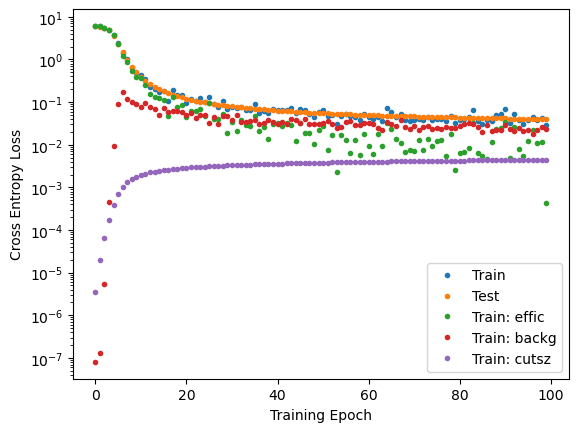

In [12]:
LearningCutsUtils.LearningCutsUtils.plotlosses(losses,losses_test)

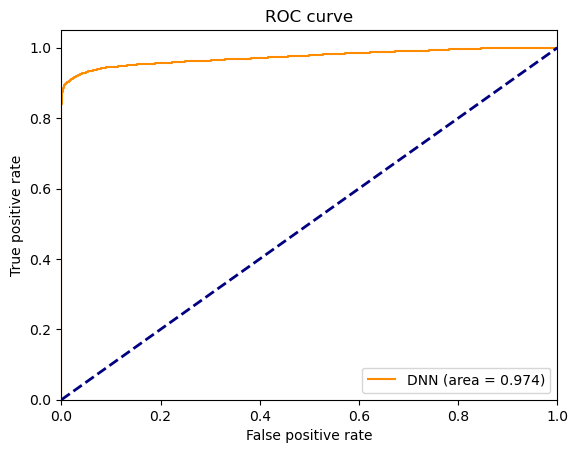

In [13]:
net.eval() # configure the model for evaluation (testing)
y_pred_test = torch.prod(net(x_test_tensor),dim=1).detach().cpu()
y_pred_train= torch.prod(net(x_train_tensor),dim=1).detach().cpu()

LearningCutsUtils.LearningCutsUtils.make_ROC_curve(y_test, y_pred_test)

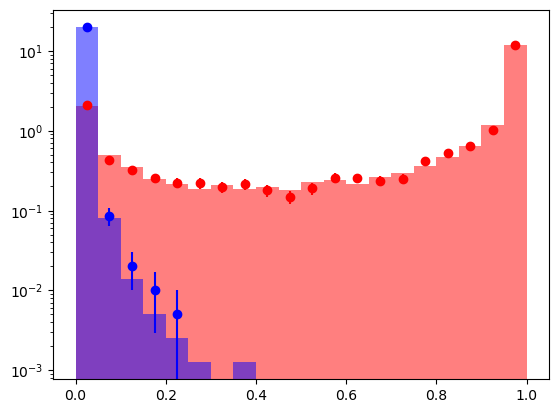

In [14]:
LearningCutsUtils.LearningCutsUtils.plot_classifier_output(y_train, y_pred_train,y_test, y_pred_test)

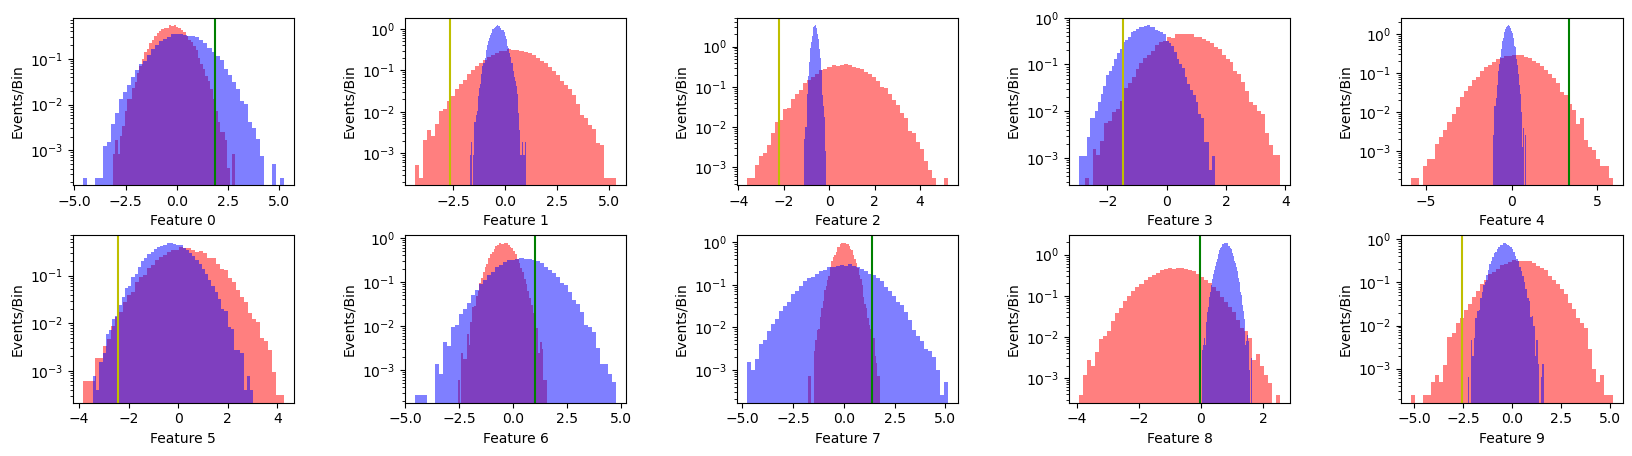

In [15]:
# Distributions after scaling

fig = plt.figure(figsize=(20,5))
fig.tight_layout()
nbins=50

biases=net[0].bias.detach().numpy()
weights=net[0].weight.detach().numpy()
scaled_cuts=-biases/weights

x_signal_scaled=sc.transform(x_signal)
x_backgr_scaled=sc.transform(x_backgr)

for b in range(m):
    ax=fig.add_subplot(2,5,1+b)
    plt.subplots_adjust(hspace=0.3,wspace=0.5)
    plt.yscale('log')
    ax.hist(x_signal_scaled[:,b],nbins,density=True,histtype='stepfilled',alpha=0.5,color='red')
    ax.hist(x_backgr_scaled[:,b],nbins,density=True,histtype='stepfilled',alpha=0.5,color='blue')
    ax.set_xlabel(f"Feature {b}")
    ax.set_ylabel("Events/Bin")
    if weights[b] < 0:
        ax.axvline(x = scaled_cuts[b], color='g') # cut is "less than"
    else:
        ax.axvline(x = scaled_cuts[b], color='y') # cut is "greater than"

In [16]:
num_pass_test=0.
num_bg_pass_test=0.
test_outputs = net[0](x_test_tensor).detach().cpu()
trues=torch.tensor(m*[True])
for i in range(len(test_outputs)):

    tt=torch.zeros(m)
    t=torch.gt(test_outputs[i],tt)

    if torch.equal(t,trues) and y_test[i]==1.:
        num_pass_test+=1
    elif torch.equal(t,trues) and y_test[i]!=1.:
        num_bg_pass_test+=1.
    

effic_test = num_pass_test / np.sum(y_test)
print(f"Signal Efficiency with net outputs: {100*effic_test:4.1f}%")

bg_effic_test = num_bg_pass_test / np.sum(1.-y_test)
print(f"Background Efficiency with net outputs: {100*bg_effic_test:6.5f}%")

Signal Efficiency with net outputs: 78.7%
Background Efficiency with net outputs: 0.00000%


# Use Efficiency Scan Network, 1 target

In [17]:
targeteffics=[0.8]
torch.manual_seed(123)
activation_input_scale_factor=8.
learning_rate=0.02
batch_size=int(len(y_train)/20.) #
epochs=100
alpha=10.   # scaling factor to tune how important hitting the target signal efficiency is
beta=10.    # scaling factor to tune how important background rejection is
gamma=1e-3  # scaling factor for how aggressively to push the cuts to zero
epsilon=0   # how much to penalize deviations

net = EfficiencyScanNetwork(m,targeteffics,cuts_gt_lt) # will take m inputs, return m*n_eff outputs
torch.save(net.state_dict(), 'net_learningbiases_effictarget.pth')
# some hyperparameters
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)
#optimizer = torch.optim.Adam(net.parameters(), lr=0.1)

In [19]:
losses = []
losses_test = []

net.load_state_dict(torch.load('net_learningbiases_effictarget.pth',weights_only=True))

xy_train = torch.utils.data.TensorDataset(x_train_tensor.float(),y_train_tensor)
loader = torch.utils.data.DataLoader(xy_train, batch_size=batch_size, shuffle=True)

debug=False

for epoch in range(epochs):
    net.train()
    start_time = time.time()
    for x_batch, y_batch in loader:
        y_pred = net(x_batch)
        optimizer.zero_grad()
        loss = effic_loss_fn(y_pred, y_batch, m, net, alpha, beta, gamma, epsilon,debug=debug)
        loss.totalloss().backward()
        optimizer.step()
    losses.append(loss)
    net.eval() # configure the model for evaluation (testing)
    y_pred = net(x_test_tensor)
    test_loss = effic_loss_fn(y_pred, y_test_tensor, m, net, alpha, beta, gamma, epsilon)
    losses_test.append(test_loss)
    end_time=time.time()
    elapsed_time = end_time - start_time
    print(f"Completed epoch {epoch:2d} in {elapsed_time:4.1f}s, Train loss={loss.totalloss().data:4.1e}, Test loss={test_loss.totalloss().data:4.1e}")

Completed epoch  0 in  0.6s, Train loss=6.3e+00, Test loss=6.3e+00
Completed epoch  1 in  0.7s, Train loss=6.3e+00, Test loss=6.3e+00
Completed epoch  2 in  0.6s, Train loss=6.2e+00, Test loss=6.2e+00
Completed epoch  3 in  0.6s, Train loss=6.2e+00, Test loss=6.2e+00
Completed epoch  4 in  0.8s, Train loss=6.2e+00, Test loss=6.2e+00
Completed epoch  5 in  0.6s, Train loss=6.2e+00, Test loss=6.1e+00
Completed epoch  6 in  0.5s, Train loss=6.1e+00, Test loss=6.1e+00
Completed epoch  7 in  0.7s, Train loss=6.0e+00, Test loss=6.0e+00
Completed epoch  8 in  0.5s, Train loss=6.0e+00, Test loss=5.9e+00
Completed epoch  9 in  0.5s, Train loss=5.8e+00, Test loss=5.7e+00
Completed epoch 10 in  0.7s, Train loss=5.5e+00, Test loss=5.5e+00
Completed epoch 11 in  0.5s, Train loss=5.1e+00, Test loss=5.1e+00
Completed epoch 12 in  0.6s, Train loss=4.6e+00, Test loss=4.7e+00
Completed epoch 13 in  0.7s, Train loss=4.1e+00, Test loss=4.1e+00
Completed epoch 14 in  0.6s, Train loss=3.4e+00, Test loss=3.5

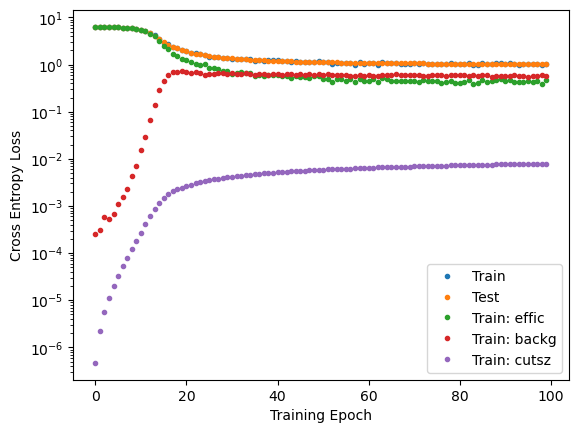

In [20]:
LearningCutsUtils.LearningCutsUtils.plotlosses(losses,losses_test)

Target efficiency: 80.0%
[ 2.442525   -3.6906543  -2.82968    -1.0083411   4.4497743  -3.2692463
  1.4356582   2.4547648  -0.12492113 -3.5145588 ]


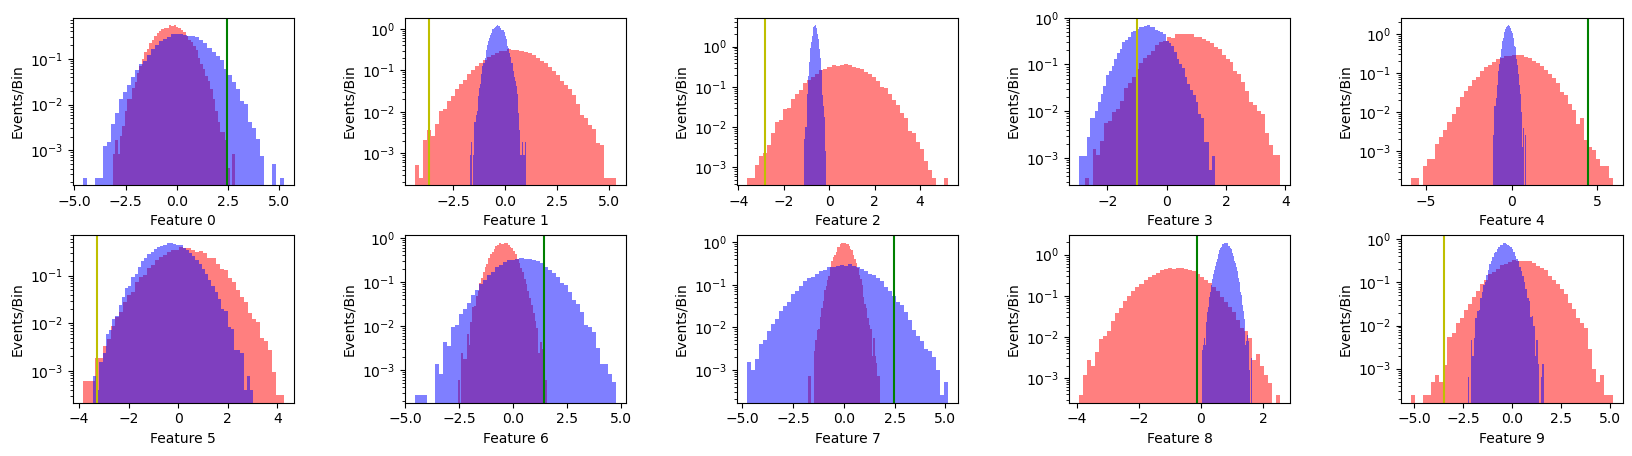

In [21]:
# Distributions after scaling
for n in range(len(targeteffics)):
    print(f"Target efficiency: {targeteffics[n]*100}%")
    fig = plt.figure(figsize=(20,5))
    fig.tight_layout()
    nbins=50
    
    biases=net.nets[n].bias.detach().numpy()
    weights=net.nets[n].weight.detach().numpy()
    scaled_cuts=-biases/weights
    print(scaled_cuts)
    
    x_signal_scaled=sc.transform(x_signal)
    x_backgr_scaled=sc.transform(x_backgr)
    
    for b in range(m):
        ax=fig.add_subplot(2,5,1+b)
        plt.subplots_adjust(hspace=0.3,wspace=0.5)
        plt.yscale('log')
        ax.hist(x_signal_scaled[:,b],nbins,density=True,histtype='stepfilled',alpha=0.5,color='red')
        ax.hist(x_backgr_scaled[:,b],nbins,density=True,histtype='stepfilled',alpha=0.5,color='blue')
        ax.set_xlabel(f"Feature {b}")
        ax.set_ylabel("Events/Bin")
        if weights[b] < 0:
            ax.axvline(x = scaled_cuts[b], color='g') # cut is "less than"
        else:
            ax.axvline(x = scaled_cuts[b], color='y') # cut is "greater than"
    plt.show()

In [22]:
num_pass_test=0.
num_bg_pass_test=0.
test_outputs = net.nets[0](x_test_tensor).detach().cpu()
trues=torch.tensor(m*[True])
for i in range(len(test_outputs)):

    tt=torch.zeros(m)
    t=torch.gt(test_outputs[i],tt)

    if torch.equal(t,trues) and y_test[i]==1.:
        num_pass_test+=1
    elif torch.equal(t,trues) and y_test[i]!=1.:
        num_bg_pass_test+=1.
    

effic_test = num_pass_test / np.sum(y_test)
print(f"Signal Efficiency with net outputs: {100*effic_test}%")

bg_effic_test = num_bg_pass_test / np.sum(1.-y_test)
print(f"Background Efficiency with net outputs: {100*bg_effic_test}%")

Signal Efficiency with net outputs: 76.68161434977578%
Background Efficiency with net outputs: 0.0%


# Multiple Efficiency targets

In [23]:
targeteffics=[0.6,0.7,0.8,0.9]
torch.manual_seed(123)
activation_input_scale_factor=8.
learning_rate=0.02
batch_size=int(len(y_train)/20.) #
epochs=100
alpha=10.   # scaling factor to tune how important hitting the target signal efficiency is
beta=10.    # scaling factor to tune how important background rejection is
gamma=1e-3  # scaling factor for how aggressively to push the cuts to zero
epsilon=1e-2   # how much to penalize deviations

net = EfficiencyScanNetwork(m,targeteffics,cuts_gt_lt) # will take m inputs, return m*n_eff outputs
torch.save(net.state_dict(), 'net_learningbiases_effictarget.pth')
# some hyperparameters
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)
#optimizer = torch.optim.Adam(net.parameters(), lr=0.1)

In [24]:
losses = []
losses_test = []

net.load_state_dict(torch.load('net_learningbiases_effictarget.pth',weights_only=True))

xy_train = torch.utils.data.TensorDataset(x_train_tensor.float(),y_train_tensor)
loader = torch.utils.data.DataLoader(xy_train, batch_size=batch_size, shuffle=True)

debug=False

for epoch in range(epochs):
    net.train()
    start_time = time.time()
    for x_batch, y_batch in loader:
        y_pred = net(x_batch)
        optimizer.zero_grad()
        loss = effic_loss_fn(y_pred, y_batch, m, net, alpha, beta, gamma, epsilon,debug=debug)
        loss.totalloss().backward()
        optimizer.step()
    losses.append(loss)
    net.eval() # configure the model for evaluation (testing)
    y_pred = net(x_test_tensor)
    test_loss = effic_loss_fn(y_pred, y_test_tensor, m, net, alpha, beta, gamma, epsilon)
    losses_test.append(test_loss)
    end_time=time.time()
    elapsed_time = end_time - start_time
    print(f"Completed epoch {epoch:2d} in {elapsed_time:4.1f}s, Train loss={loss.totalloss().data:4.1e}, Test loss={test_loss.totalloss().data:4.1e}")

Completed epoch  0 in  0.9s, Train loss=2.3e+01, Test loss=2.3e+01
Completed epoch  1 in  0.9s, Train loss=2.3e+01, Test loss=2.3e+01
Completed epoch  2 in  1.1s, Train loss=2.2e+01, Test loss=2.2e+01
Completed epoch  3 in  0.8s, Train loss=2.2e+01, Test loss=2.2e+01
Completed epoch  4 in  0.8s, Train loss=2.2e+01, Test loss=2.2e+01
Completed epoch  5 in  0.9s, Train loss=2.2e+01, Test loss=2.2e+01
Completed epoch  6 in  0.8s, Train loss=2.2e+01, Test loss=2.2e+01
Completed epoch  7 in  0.9s, Train loss=2.2e+01, Test loss=2.2e+01
Completed epoch  8 in  1.1s, Train loss=2.1e+01, Test loss=2.1e+01
Completed epoch  9 in  0.8s, Train loss=2.1e+01, Test loss=2.1e+01
Completed epoch 10 in  0.7s, Train loss=2.0e+01, Test loss=2.0e+01
Completed epoch 11 in  0.9s, Train loss=1.8e+01, Test loss=1.8e+01
Completed epoch 12 in  0.8s, Train loss=1.6e+01, Test loss=1.7e+01
Completed epoch 13 in  0.7s, Train loss=1.5e+01, Test loss=1.5e+01
Completed epoch 14 in  1.0s, Train loss=1.4e+01, Test loss=1.3

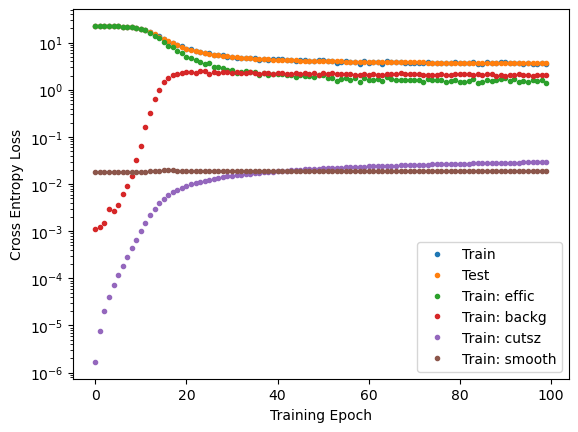

In [25]:
LearningCutsUtils.LearningCutsUtils.plotlosses(losses,losses_test)

In [26]:
for n in range(len(targeteffics)):
    print(f"Target efficiency: {targeteffics[n]*100}%")
    
    num_pass_test=0.
    num_bg_pass_test=0.
    test_outputs = net.nets[n](x_test_tensor).detach().cpu()
    trues=torch.tensor(m*[True])
    for i in range(len(test_outputs)):
    
        tt=torch.zeros(m)
        t=torch.gt(test_outputs[i],tt)
    
        if torch.equal(t,trues) and y_test[i]==1.:
            num_pass_test+=1
        elif torch.equal(t,trues) and y_test[i]!=1.:
            num_bg_pass_test+=1.
        
    
    effic_test = num_pass_test / np.sum(y_test)
    print(f"Signal Efficiency with net outputs: {100*effic_test:4.1f}%")
    
    bg_effic_test = num_bg_pass_test / np.sum(1.-y_test)
    print(f"Background Efficiency with net outputs: {100*bg_effic_test:6.5f}%")

Target efficiency: 60.0%
Signal Efficiency with net outputs: 66.7%
Background Efficiency with net outputs: 0.00000%
Target efficiency: 70.0%
Signal Efficiency with net outputs: 71.9%
Background Efficiency with net outputs: 0.00000%
Target efficiency: 80.0%
Signal Efficiency with net outputs: 76.7%
Background Efficiency with net outputs: 0.00000%
Target efficiency: 90.0%
Signal Efficiency with net outputs: 80.3%
Background Efficiency with net outputs: 0.00000%


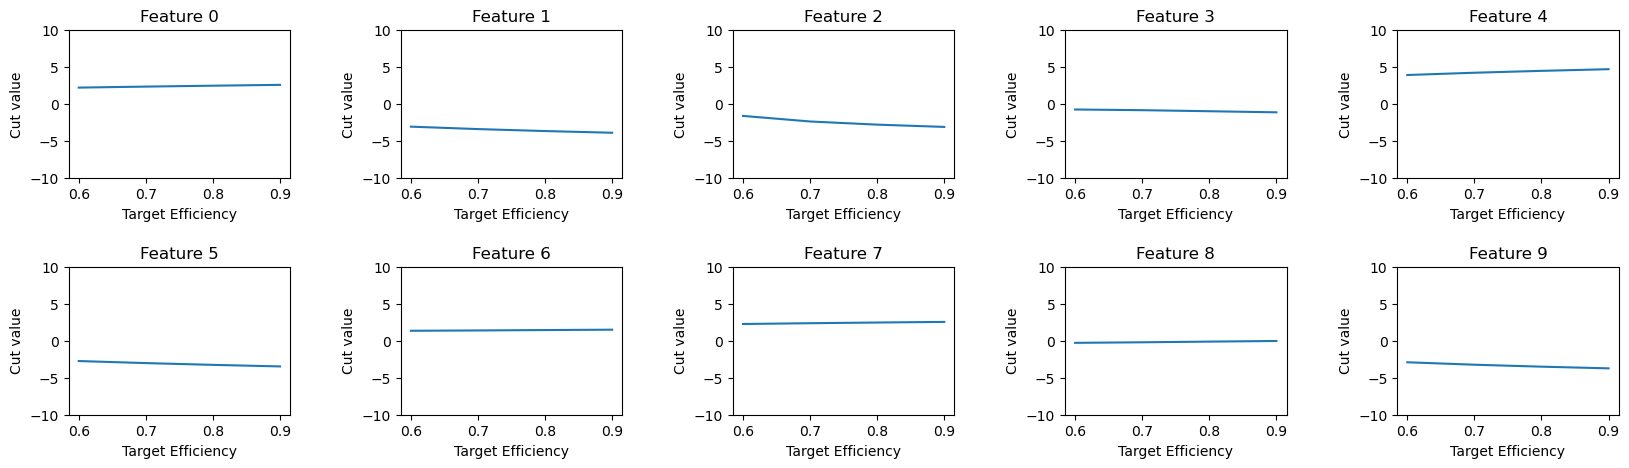

In [27]:
# Distributions of cuts
fig = plt.figure(figsize=(20,5))
fig.tight_layout()

scaled_cuts=[len(targeteffics)*[0] for i in range(m)]
for n in range(len(targeteffics)):
    biases=net.nets[n].bias.detach().numpy()
    weights=net.nets[n].weight.detach().numpy()
    cuts=(-biases/weights)
    for f in range(m):
        cutval=cuts[f]
        scaled_cuts[f][n]=cutval
for b in range(m):
    ax=fig.add_subplot(2,5,1+b)
    plt.subplots_adjust(hspace=0.6,wspace=0.5)
    ax.plot(targeteffics,scaled_cuts[b])
    ax.set_xlabel(f"Target Efficiency")
    ax.set_ylabel("Cut value")
    ax.set_title(f"Feature {b}")
    ax.set_ylim([-10,10])

Target efficiency: 60.0%
Cuts are: [ 2.182454   -3.0922148  -1.6388755  -0.7749447   3.8832304  -2.749451
  1.3391426   2.2544632  -0.29138038 -2.9166696 ]


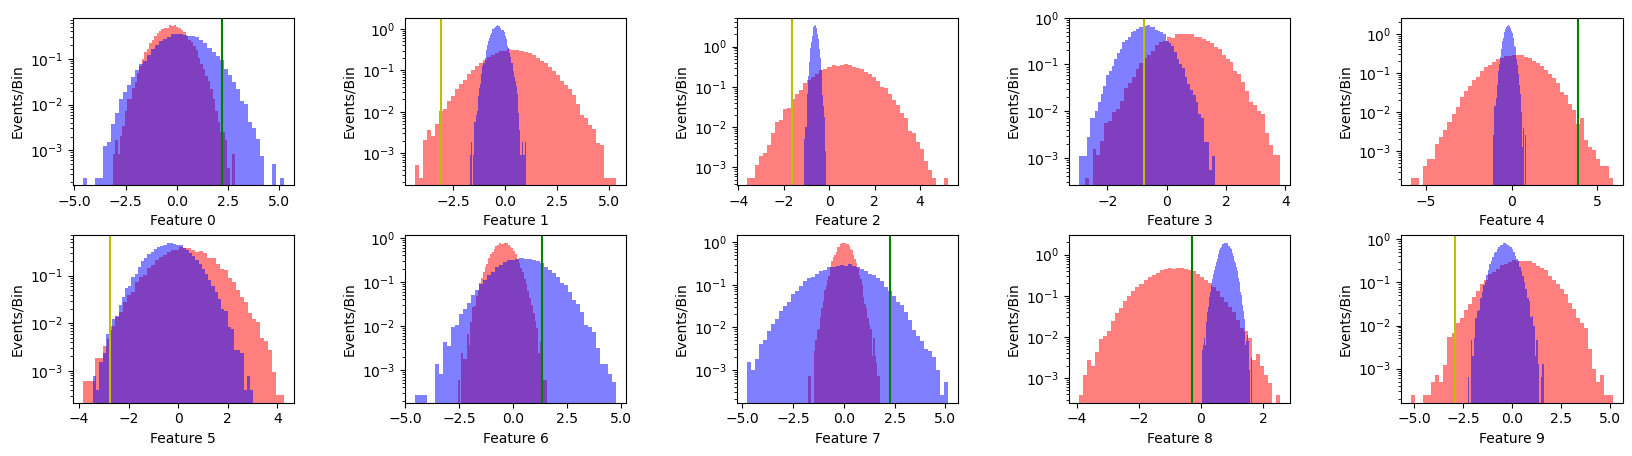

Target efficiency: 70.0%
Cuts are: [ 2.3175566  -3.420488   -2.3937097  -0.86694866  4.1910057  -3.027007
  1.3827121   2.3598542  -0.2166826  -3.2448058 ]


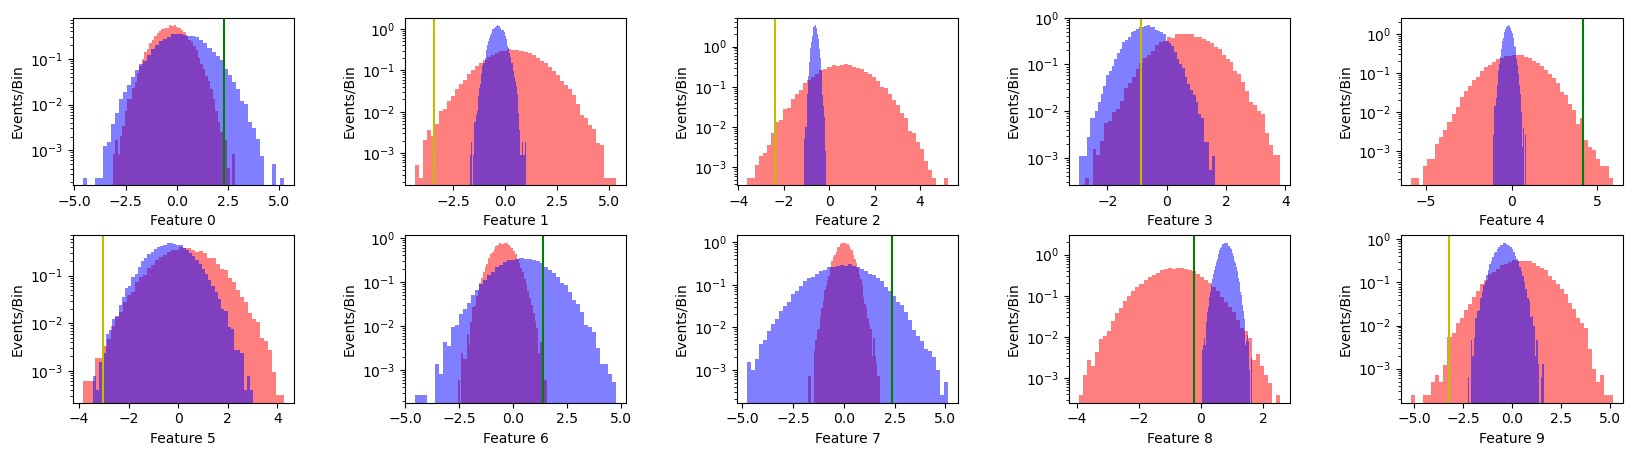

Target efficiency: 80.0%
Cuts are: [ 2.4406838  -3.6854515  -2.8206174  -1.0081791   4.444806   -3.2647867
  1.4355704   2.453415   -0.12538058 -3.5093882 ]


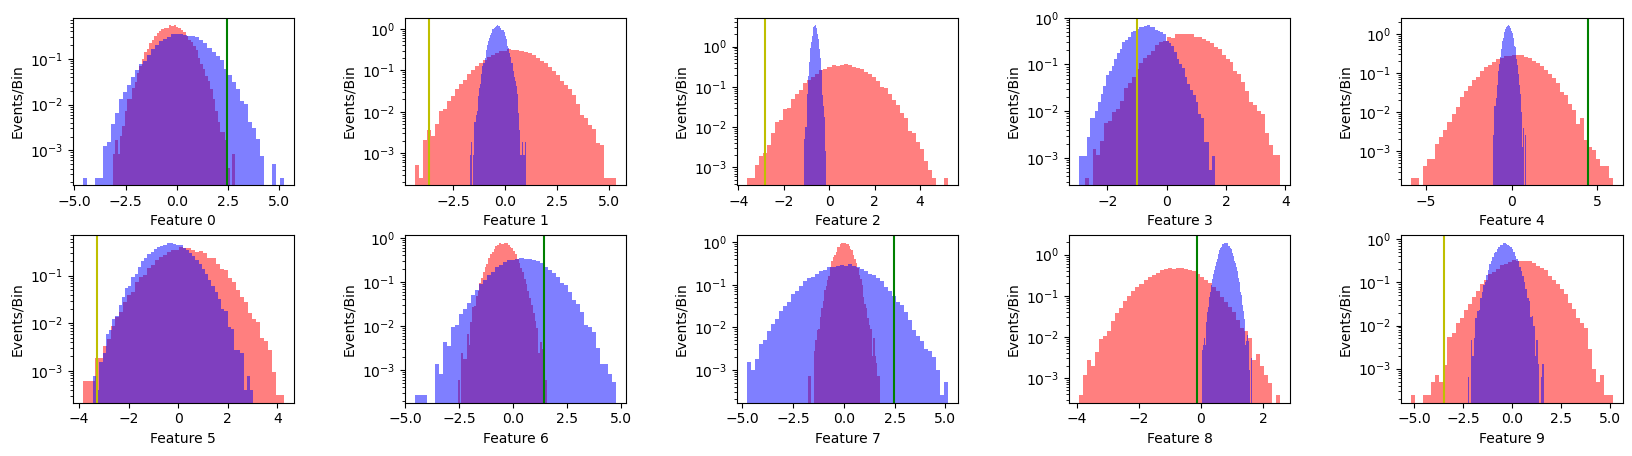

Target efficiency: 90.0%
Cuts are: [ 2.5535212  -3.915059   -3.126931   -1.1560935   4.668185   -3.4771557
  1.4858133   2.536769   -0.03987391 -3.7367525 ]


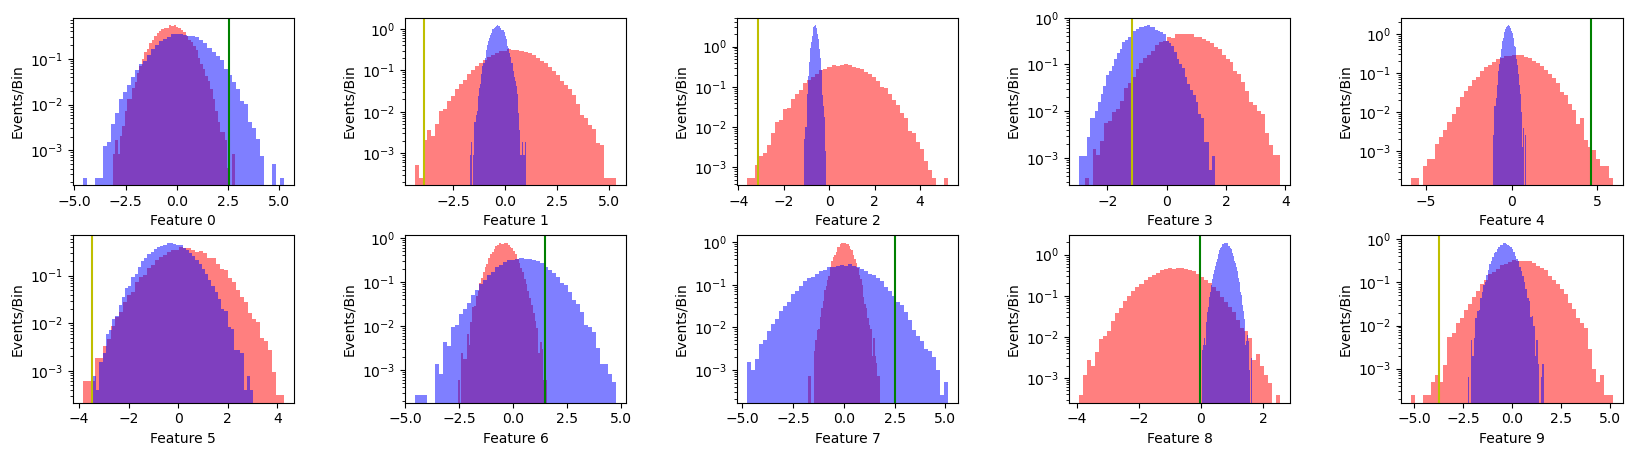

In [28]:
# Distributions after scaling
for n in range(len(targeteffics)):
    print(f"Target efficiency: {targeteffics[n]*100}%")
    fig = plt.figure(figsize=(20,5))
    fig.tight_layout()
    nbins=50
    
    biases=net.nets[n].bias.detach().numpy()
    weights=net.nets[n].weight.detach().numpy()
    scaled_cuts=-biases/weights
    print(f"Cuts are: {scaled_cuts}")
    
    x_signal_scaled=sc.transform(x_signal)
    x_backgr_scaled=sc.transform(x_backgr)
    
    for b in range(m):
        ax=fig.add_subplot(2,5,1+b)
        plt.subplots_adjust(hspace=0.3,wspace=0.5)
        plt.yscale('log')
        ax.hist(x_signal_scaled[:,b],nbins,density=True,histtype='stepfilled',alpha=0.5,color='red')
        ax.hist(x_backgr_scaled[:,b],nbins,density=True,histtype='stepfilled',alpha=0.5,color='blue')
        ax.set_xlabel(f"Feature {b}")
        ax.set_ylabel("Events/Bin")
        if weights[b] < 0:
            ax.axvline(x = scaled_cuts[b], color='g') # cut is "less than"
        else:
            ax.axvline(x = scaled_cuts[b], color='y') # cut is "greater than"
    plt.show()